<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt                        
import torch
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# LSTM

In [2]:
# load data

ts_data = pd.read_csv('./A2Benchmark/synthetic_26.csv',index_col = 0)
#ts_data = ts_data.astype('float')
ts_data.head()
a = list(ts_data.columns)
a[1] = 'is_anomaly'
ts_data.columns = a

In [3]:
ts_data[['is_anomaly','value']].groupby('is_anomaly').count()

,value
is_anomaly,
0,1412
1,9


In [4]:
# define train, valid, test

train_percent = int(0.3*len(ts_data))
valid_percent = int(0.1*len(ts_data))
test_percent = int(0.6*len(ts_data))

train_data = list(ts_data.iloc[:train_percent,0])
valid_data = list(ts_data.iloc[train_percent:train_percent+valid_percent,0])
test_data = list(ts_data.iloc[train_percent+valid_percent:,0])

In [5]:
# set hyperparameters

w = 45
pred_window = w
n_layers = 2
hidden_dim = 256
kernel_size = 2
stride = 1
pool_size = 2

output_size = 1

In [6]:
# split dataset into subsequences on which we will train

def get_subsequences(data):
    X = []
    Y = []
    idx = []
    
    for i in range(len(data) - w):
        mean = np.mean(data[i:i+w])
        std = np.std(data[i:i+w])
        X.append((data[i:i+w]))
        Y.append((data[i+1:i+w+1]))
        idx.append(ts_data.index[train_percent+valid_percent+i+w])
    return np.array(X),np.array(Y),idx

trainX,trainY,_ = get_subsequences(train_data)
trainX = np.reshape(trainX,(1,trainX.shape[0],trainX.shape[1]))
print(trainX.shape)

validX,validY,_ = get_subsequences(valid_data)
print(validY.shape)
validX = np.reshape(validX,(1,validX.shape[0],validX.shape[1]))

testX,testY,test_idx = get_subsequences(test_data)
testX = np.reshape(testX,(1,testX.shape[0],testX.shape[1]))
print(testX.shape)

batch_size = trainX.shape[1]

size_valid = validX.shape[1]
size_test = testX.shape[1]

(1, 381, 45)
(97, 45)
(1, 808, 45)


In [7]:
# LSTM model definition

class LSTM(nn.Module):
    
    def __init__(self,batch_size):

        super(LSTM, self).__init__()
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size=w,hidden_size=hidden_dim,num_layers = n_layers,dropout=0.5)
        self.fc = nn.Linear(hidden_dim,pred_window)
        self.dropout = nn.Dropout(0.5)
    
    
    def forward(self, x, hidden):
        
        batch_size = x.shape[1]
       # print(x.shape)
        x,hidden = self.lstm(x,hidden)
        x = x.contiguous().view(-1, hidden_dim)
        x = self.dropout(x)
        out =  (self.fc(x))
        out = out.view(batch_size,-1,pred_window)
        out = out[:,-1]

        return out, hidden
    
    
    def init_hidden(self,size):

        weight = next(self.parameters()).data

        hidden = (weight.new(n_layers, size, hidden_dim).zero_(),
                      weight.new(n_layers, size, hidden_dim).zero_())

        return hidden


In [8]:
# define LSTM model

lstm = LSTM(batch_size)
print(lstm)

LSTM(
  (lstm): LSTM(45, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=256, out_features=45, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [53]:
# loss and optimizer declaration

criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr = 1e-4,weight_decay=1e-6)

In [10]:
# function for fwd/back prop
def forward_back_prop(lstm, optimizer, criterion, inp, target, hidden):
        
    hidden = tuple([each.data for each in hidden])
    lstm.zero_grad()
    output, hidden = lstm(inp, hidden)
    loss = criterion(output.squeeze(), target)
    loss.backward()
    nn.utils.clip_grad_norm_(lstm.parameters(), 5)
    optimizer.step()

    return loss.item(), hidden

# function to train LSTM model
def train_lstm(n_epochs, trainX,trainY, validX,validY,lstm, optimizer, criterion,save_path,freq = 5):

    target_train = torch.tensor(trainY).type('torch.FloatTensor')
    data_train = torch.tensor(trainX).type('torch.FloatTensor')
    
    target_valid = torch.tensor(validY).type('torch.FloatTensor')
    data_valid = torch.tensor(validX).type('torch.FloatTensor')
    
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    last_valid_loss = 0

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch in range(1, n_epochs + 1):
        
        # Training
        hidden = lstm.init_hidden(batch_size)

        lstm.train()
        train_loss,hidden = forward_back_prop(lstm,optimizer,criterion,data_train,target_train,hidden)
        
        # Validation
        lstm.eval()
        hidden_valid = lstm.init_hidden(size_valid)
        output_valid,hidden_valid = lstm(data_valid,hidden_valid)
        
        loss_valid = criterion(output_valid.squeeze(), target_valid)
        valid_loss = loss_valid.item()
        if(valid_loss == last_valid_loss):
            print('problem')
            
        last_valid_loss = valid_loss
        if(epoch%freq == 0):
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))
            
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(lstm.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
    return lstm

In [54]:
# model training

train_loss_list = []
valid_loss_list = []
lstm = train_lstm(500, trainX,trainY, validX,validY, lstm, optimizer, 
                      criterion,'lstm_A1.pt',freq = 10)

Training for 500 epoch(s)...
Validation loss decreased (inf --> 265.353546).  Saving model ...
Validation loss decreased (265.353546 --> 265.350891).  Saving model ...
Validation loss decreased (265.350891 --> 265.339630).  Saving model ...
Epoch: 10 	Training Loss: 233.494370 	Validation Loss: 265.395874
Epoch: 20 	Training Loss: 233.498428 	Validation Loss: 265.512024
Epoch: 30 	Training Loss: 234.974869 	Validation Loss: 265.501312
Epoch: 40 	Training Loss: 238.244873 	Validation Loss: 265.431213
Epoch: 50 	Training Loss: 234.327835 	Validation Loss: 265.391052
Epoch: 60 	Training Loss: 234.505203 	Validation Loss: 265.379608
Validation loss decreased (265.339630 --> 265.300140).  Saving model ...
Validation loss decreased (265.300140 --> 265.287415).  Saving model ...
Epoch: 70 	Training Loss: 234.903870 	Validation Loss: 265.293457
Epoch: 80 	Training Loss: 233.974976 	Validation Loss: 265.299103
Validation loss decreased (265.287415 --> 265.265350).  Saving model ...
Validation l

In [55]:
# load best model (previously saved)

lstm.load_state_dict(torch.load('lstm_A1.pt'))

<All keys matched successfully>

In [56]:
# make predictions

test_tensor =  torch.tensor(testX).type('torch.FloatTensor')
lstm.eval()
hidden = lstm.init_hidden(size_test)
out,hidden = lstm(test_tensor,hidden)
out = out.detach().numpy()
out[:,-1].shape

(808,)

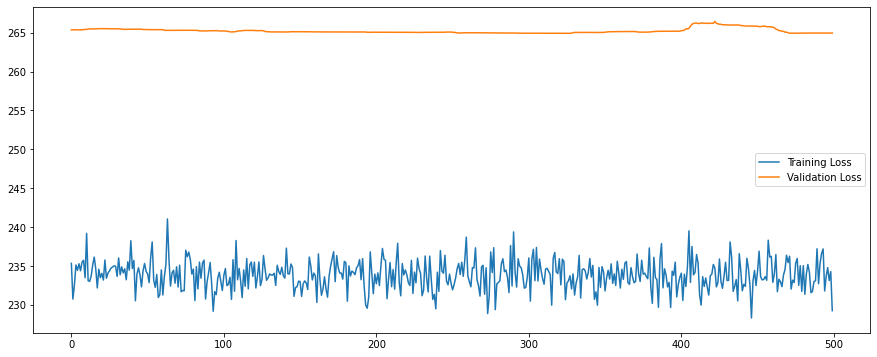

In [57]:
# plot losses

fig,axs = plt.subplots(1,1,figsize = (15,6))
axs.plot(train_loss_list)
axs.plot(valid_loss_list)
axs.legend(['Training Loss','Validation Loss'])
plt.savefig('validation.jpg')

In [58]:
df_out = pd.DataFrame()
df_out['pred'] = out[:,-1]
df_out['actual'] = testY[:,-1]
#df_out.index = ts_data.index[train_percent + valid_percent:len(ts_data)-w-pred_window]

df_out.tail()

,pred,actual
803,1658.600952,1159.791552
804,1655.872070,397.486829
805,1609.425537,1231.864469
806,1628.771973,1699.693308
807,1606.292603,1477.151920


In [59]:
# calc prediction error

df_out['error'] =np.abs(df_out['pred'] - df_out['actual'])
error_mean = df_out['error'].rolling(window = 45).mean()
error_std = df_out['error'].rolling(window = 45).std()
error_mean.fillna(method='bfill',inplace=True)
error_std.fillna(method='bfill',inplace=True)
df_out['error_n'] = (df_out['error'] - df_out['error'].mean())/df_out['error'].std()
#df_out.index = ts_data.index[train_percent +valid_percent+w+1-1:-w]
df_out.index = test_idx

In [68]:
# define anomaly if beyond 3 sigma

thresh = df_out.loc[df_out['error_n'].abs() >3]
thresh['is_anomaly'] = ts_data.loc[thresh.index,'is_anomaly']
thresh

C:\Users\amand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pred,actual,error,error_n,is_anomaly
1418968800,1561.500000,3755.844471,2194.344471,3.583707,1
1418972400,1561.092407,3755.844471,2194.752064,3.584642,1
1418976000,1561.092407,3755.844471,2194.752064,3.584642,1
1419094800,-145.216599,2041.956620,2187.173218,3.567248,1
1419098400,-92.244240,2041.956620,2134.200860,3.445674,1
1419102000,-57.593636,2041.956620,2099.550255,3.366150,1
1420945200,-1230.764771,772.095727,2002.860497,3.144242,0
1421362800,-1092.499268,933.320908,2025.820176,3.196936,0


In [69]:
# calc TP, FN, FP, TN

positives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 1].index
negatives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 0].index
tp = []
fn = []
fp = []
tn = []
for p in positives:
    if p in thresh.index:
        tp.append(p)
    else:
        fn.append(p)

for n in negatives:
    if n in thresh.index:
        fp.append(n)
    else:
        tn.append(n)

In [70]:
# calc f-score

recall = len(tp)/(len(tp)+len(fn))
precision = len(tp)/(len(tp)+len(fp))
F_score = 2* recall*precision/(recall + precision)
F_score

0.7058823529411765

In [71]:
len(tp)

6

In [72]:
len(fn)

3

In [73]:
df = pd.DataFrame()
df.loc['Total Positives','Val'] = int(len(positives))
df.loc['Total Negatives','Val'] = int(len(negatives))
df.loc['True Positive','Val'] = int(len(tp))
df.loc['False Postive','Val'] = int(len(fp))
df.loc['True Negative','Val'] = int(len(tn))
df.loc['False Negative','Val'] = int(len(fn))
df.loc['F-score','Val'] = F_score

In [74]:
# model prediction summary

df

,Val
Total Positives,9.000000
Total Negatives,799.000000
True Positive,6.000000
False Postive,2.000000
True Negative,797.000000
False Negative,3.000000
F-score,0.705882


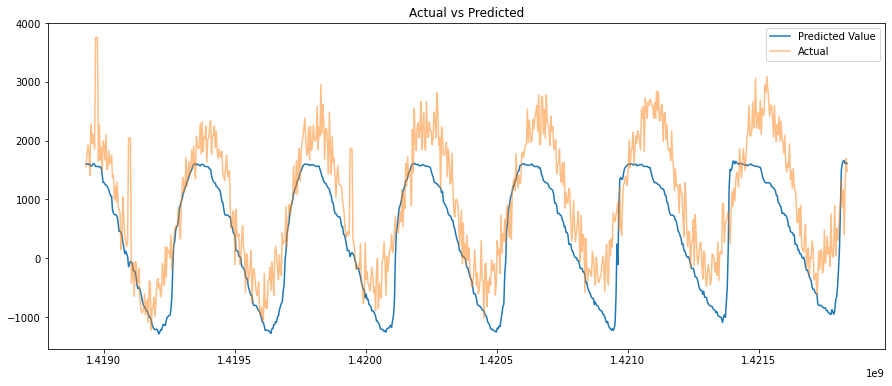

In [75]:
# plot test data and prediction

fig,axs = plt.subplots(1,1,figsize = (15,6))
axs.plot(df_out['pred'])
axs.plot(df_out['actual'],alpha = 0.5)
axs.set_title('Actual vs Predicted')
axs.legend(['Predicted Value','Actual'])
#plt.savefig('real_37.jpg')
plt.savefig('synthetic_26.jpg')

In [488]:
# output df

df_out

,pred,actual,error,error_n
timestamp,,,,
1420977600,-8.261481,708.350987,716.612468,0.757153
1420981200,-8.260743,740.067599,748.328342,0.881898
1420984800,-8.261151,757.815084,766.076235,0.951704
1420988400,-8.267326,764.074517,772.341843,0.976348
1420992000,-8.260720,773.919262,782.179982,1.015043
...,...,...,...,...
1421820000,-8.224688,704.830494,713.055182,0.743162
1421823600,-8.260543,724.648254,732.908797,0.821250
1421827200,-8.261003,699.915525,708.176529,0.723973
